# SciPy Minimize

## Multidimensional Methods

* [Gradients and Hessians](#gradients_hessians)
* [Routine Comparison](#routine_comparison)
* [Bounds](#bounds)
* [Constraints](#constraints)

In [2]:
# Importing the packages for the example
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

### Function Form

The routine `minimize` optimizes over an array variable.  Each component of the array represents a dimension.  Any additional function variables are parameters that can be passed via the flag `args=` to the routine.

$$
\text{min}_{\vec{x} \in U} f(\vec{x}| a, ...) 
$$

In [62]:
# Simplest test function
f = lambda x : x[0]**2 + x[1]**2 + x[0]*x[1]

# Test function that uses a parameter a
f_parameter = lambda x , a: x[0]**2 + (x[1]-a)**2 + x[0]*(x[1]-a)

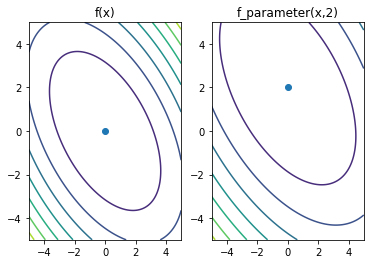

In [64]:
# Coordinates for plotting
x0 = np.arange(-5,5,.01)
x1 = np.arange(-5,5,.01)
x0_a, x1_a = np.meshgrid(x0,x1)

# plotting our test functions
fig, ax = plt.subplots(1,2)
ax[0].contour(x0_a,x1_a,f([x0_a,x1_a]))
ax[0].set_title('f(x)')

ax[1].contour(x0_a,x1_a,f_parameter([x0_a,x1_a],2))
ax[1].set_title('f_parameter(x,2)')

# Only run if you have already run the optimization routines
ax[0].scatter(result.x[0],result.x[1],label='Optimum')
ax[1].scatter(result_parameter.x[0],result_parameter.x[1],label='Optimum')

In [60]:
result=optimize.minimize(f,[1,1])
print(result)

      fun: 1.5869182200826406e-16
 hess_inv: array([[ 0.66666667, -0.33333333],
       [-0.33333333,  0.66666667]])
      jac: array([-6.91799246e-09, -6.91799246e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-7.27305122e-09, -7.27305122e-09])


### `args` and function parameters

In [63]:
result_parameter=optimize.minimize(f_parameter,[1,1],args=(2))
print(result_parameter)

      fun: 5.07141378015679e-17
 hess_inv: array([[ 1.00000000e+00, -5.04924491e-09],
       [-5.04924491e-09,  1.00000001e+00]])
      jac: array([8.03005551e-10, 6.09882383e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-6.46465798e-09,  2.00000000e+00])


<div id="gradients_hessians" />

### Gradients and Hessians

Note: function returns need to be NumPy arrays

Rountines in the Newton-type category use the first derivative gradient (Jacobian) and potentially second derivative Hessian.  

In [22]:
def df (x):
    df_dx0 = 2*x[0] + x[1]
    df_dx1 = 2*x[1] + x[0]
    return np.array([df_dx0, df_dx1])

def d2f (x): 
    d2f_dx02 = 2
    d2f_dx12 = 2
    d2f_dx1dx0 = 1
    return np.array([[d2f_dx02, d2f_dx1dx0],
                    [ d2f_dx1dx0 , d2f_dx12]])

And how to pass that to minimize:

In [44]:
optimize.minimize(f,[1,1],jac=df)

      fun: 3.697785493223493e-32
 hess_inv: array([[ 0.66666667, -0.33333333],
       [-0.33333333,  0.66666667]])
      jac: array([3.33066907e-16, 3.33066907e-16])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([1.11022302e-16, 1.11022302e-16])

In [18]:
# how does f return derivative with itself?
#optimize.minimize([f,df],[1,1],jac=True)

And to add the Hessian, I change the method to `Newton-CG`, as that method actually uses the Hessian:

In [46]:
optimize.minimize(f,[1,1],jac=df,hess=d2f,method='Newton-CG')

     fun: 0.0
     jac: array([0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 3
    nhev: 2
     nit: 2
    njev: 4
  status: 0
 success: True
       x: array([0., 0.])

Let's just double check our manual derivatives.  Maybe something went wrong.  Luckily, `optimize` provides a rountine for this:

In [103]:
optimize.check_grad(f,df,[1,1])

0.0

By returning `0.0`, the rountine confirms that our manual gradient is identical to a finite derivative method at `[1,1]`.

If we don't provide derivative functions, `minimize` will use a finite derivative approximation. We can take a look at this finite derivative method itself:

In [102]:
optimize.approx_fprime([1,1],f, np.array([1e-6,1e-6]) )

array([3.000001, 3.000001])

#### Hessian shortcut

If the entire Hessian is too unwieldy to calculate, the Hessian times a vector $ \mathbf{H} \vec{p}$ can be used instead for certain methods like Newton- CG.

<div id="routine_comparison" />

### Routine Comparison

Right now, this is just a bunch of scribbled notes...

* Computational intensity of one evaluation
* Derivatives
    * Even differentiable?
* Number of dimensions
* Constraints
* Convexity of function

| Routine | Gradient | Hessian | Line Search | Constraints |
| --- | --- | --- | --- | --- | 
| Nelder- Mead | no | no | no | no | 
| Powell | no | no | yes | no | 
| Conjugate Gradient |  yes | no | no | no | 
| BFGS | yes | approximated | no | no | 
| L-BFGS | 

Nelder-Mead simplex method: Derivative free optimization

Gradient/ Line Methods: 
* Conjugate Gradient
* Newton-CG (zeros the gradient) good if cheap hessian


L-BFGS suitable for large numbers of variables
Quasi-Newton methods: Hessian approximated by recent evaluations

Constraints: 
* Constrained optimization by linear approximation COBYLA
* Sequential Quadratic Programming SLSQP
* trust-constr
* TNC? truncated newton algorithm
* L-BFGS-B


Hessian postivie definate?

What means to be large scale problem?

So we have newton-cg AND TNC, same thing, but TNC permits bounds

<div id="bounds" />

### Bounds

Work on TNC, L-BFGS-B, and trust-constr

For example, a hard box:
$$
0 < x_0<1, 2<x_1 <3
$$


Text(0, 0.5, 'x1')

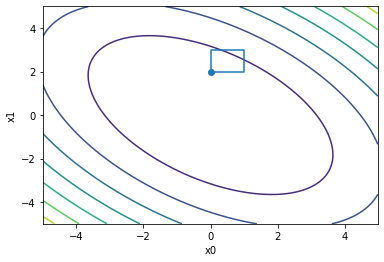

In [67]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.plot([0,0,1,1,0],[2,3,3,2,2],label='Bounds')

# only if you have already run the optimization
ax.scatter(result_bounds.x[0],result_bounds.x[1])

ax.set_xlabel('x0')
ax.set_ylabel('x1')

In [66]:
# create bounds object array of lower limits then array of upper limits
bounds=optimize.Bounds([0,2],[1,3])
result_bounds=optimize.minimize(f,[1.5,1.5],bounds=bounds)
print(result_bounds)

      fun: 4.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.99999999, 3.99999998])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 1
   status: 0
  success: True
        x: array([0., 2.])


<div id="constraints" />

### Constraints for `trust-constr`

Note: `trust-constr` requires gradient and hessian

#### Linear Constraint

$$
-\infty< x_1 < 2 x_0 - 3
$$
$$
-\infty < - 1  x_1 + 2 x_0 < -3
$$
we can reformulate it in a general form
$$
n_{lower} < \vec{A} \vec{x} < n_{upper}
$$
with a lower and upper bound $n_{lower}$ and $n_{upper}$ and a vector of coefficients $A$.

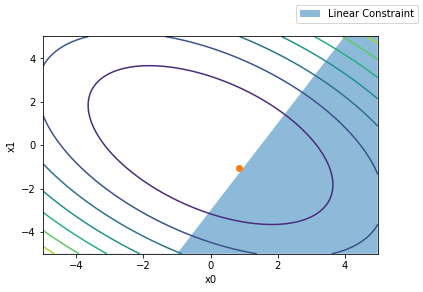

In [82]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.fill_between(x0,2*x0-3,-5,alpha=0.5,label='Linear Constraint')

# only if you already have run the optimization
ax.scatter(result_linearconstraint.x[0],result_linearconstraint.x[1])

ax.set_xlabel('x0')
ax.set_ylabel('x1')
fig.legend()

In [85]:
n_lower=-np.inf
n_upper=-3
A=[-1,2]

linear_constraint = optimize.LinearConstraint(A,n_lower,n_upper)
result_linearconstraint=optimize.minimize(f,[2,0],
                    method='trust-constr',jac=df,hess=d2f,
                  constraints=linear_constraint)
print(result_linearconstraint)

 barrier_parameter: 0.0008000000000000003
 barrier_tolerance: 0.0008000000000000003
          cg_niter: 7
      cg_stop_cond: 1
            constr: [array([-3.0012526])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.015523195266723633
               fun: 0.9650911253572675
              grad: array([ 0.64312556, -1.28625111])
               jac: [array([[-1,  2]])]
   lagrangian_grad: array([ 1.39769529e-09, -2.79539103e-09])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 5
              nhev: 5
               nit: 8
             niter: 8
              njev: 5
        optimality: 2.795391029764005e-09
            status: 1
           success: True
         tr_radius: 1170.0846842257092
                 v: [array([0.64312556])]
                 x: array([ 0.85750074, -1.07187593])


#### Non-linear Constraint
$$
(x_0-1)^2 < x_1
$$
Or 
$$
-\infty < x_0^2 -2 x_0 - x_1 < -1
$$
We can think of this in a form of 
$$
n_{lower} < c(x) < n_{upper}
$$

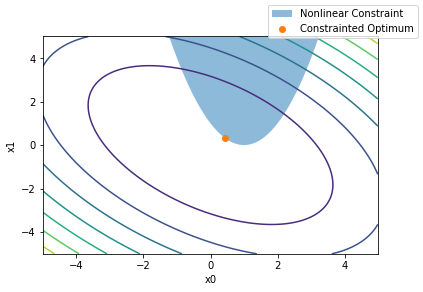

In [59]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.fill_between(x0,(x0-1)**2,5,alpha=0.5,label='Nonlinear Constraint')

# Only run if you already ran the optimization below, otherwise comment out
ax.scatter(result_nonlinearconstraint.x[0],result_nonlinearconstraint.x[1],label='Constrainted Optimum')

ax.set_xlabel('x0')
ax.set_ylabel('x1')
fig.legend()

In [83]:
n_lower=-np.inf
n_upper= -1

c = lambda x : x[0]**2 - 2* x[0] - x[1]

nonlinear_constraint=optimize.NonlinearConstraint(c,n_lower,n_upper)

In [84]:
result_nonlinearconstraint=optimize.minimize(f,[2,0],method='trust-constr',jac=df,hess=d2f,
                  constraints=nonlinear_constraint)
print(result_nonlinearconstraint)

 barrier_parameter: 6.400000000000003e-06
 barrier_tolerance: 6.400000000000003e-06
          cg_niter: 21
      cg_stop_cond: 1
            constr: [array([-1.000006])]
       constr_nfev: [39]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.024695873260498047
               fun: 0.4299350463883316
              grad: array([1.19394029, 1.06674145])
               jac: [array([[-1.11924057, -1.        ]])]
   lagrangian_grad: array([-7.57127272e-09,  8.47408210e-09])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 13
              nhev: 13
               nit: 19
             niter: 19
              njev: 13
        optimality: 8.47408210269407e-09
            status: 1
           success: True
         tr_radius: 218750.0
                 v: [array([1.06674144])]
                 x: array([0.44037971, 0.31318087])


Enforcing nonlinear constraints uses the gradient and hessian.  Just like for the general functions, the derivatives for the constraints can be provided and the method of calculation can be controlled.

<div id="dic_constraint" />

### Dictionary Constraints

Used for SLSQP

Equality constraint
$$
c(x) = 0 
$$

Inequality Constraint
$$
c(x) \geq 0
$$